## Постановка задачи
Поставлена задача выяснить с каким мировым индексом или ценами на конкретный товар связан интересующий Вас финансовый инструмент. При сравнении самих значений цен Вы получаете зависимость как бы на макро уровне. Куда интересней определить связь активов на микро уровне, в частности связи доходностей. Поэтому советую перейти к доходностям активов,например так
$$ r_t= ln(\frac{S_t}{S_{t-1}})$$
Но самое главное не забыть синхронизировать данные по времени. Если в какой то день данных нет, то лучше исключить это число для всех инструментов.

Номер Вашего варианта соответствует номеру в группе

У 11 номера в таблице - 1 вариант, у 12 - второй и так далее.

Все выводы должны быть строго статистически обоснованы результатами вычислений и соответствующими текстовыми комментариями.

## Цель теста

Регрессионый анализ котировок дневных цен закрытия предложенных в варианте инструментов.


Текст задания одинаков для всех вариантов, разные только данные в каждом варианте.

*	Импортировать дневные цены закрытия перечисленных товаров,валют, индексов  и акций за последние 2 года
*	Импортированные данные должны быть синхронизированы по времени. При необходимости произвести синхронизацию. Отсутсвующие в некотором интрументе даты следует удалить из всех инструментов.
*	Перейти к логарифмическим доходностям
	$$r_t=ln(S_t/S_{t-1})=ln(S_t)-ln(S_{t-1}$$
*	Построить регрессионную модель
	$$y_t=a_0+a_1 x_{t,1}+⋯+a_p x_{t,p}+\epsilon_t$$

*	Определить значимые и незначимые предикторы. Ответ обосновать статистическими результатами.
* 	Проверить помогает ли регуляризация (L1, L2, ElasticNet)
* 	Ответить и обосновать ответ на вопрос "Является ли модель не вырожденной?"
*	Переоценить модель только для значимых переменных

Вариант 10

Зависимая переменная

    Акции Лукойл https://www.finam.ru/profile/moex-akcii/lukoil/export/

Предикторы

    Индекс S&P500 https://www.finam.ru/profile/mirovye-indeksy/sandp-500/export/
    Золото https://www.finam.ru/profile/tovary/gold/export/
    Нефть.Брент https://www.finam.ru/profile/tovary/brent/export/
    Медь https://www.finam.ru/profile/tovary/copper/export/
    USD / Euro https://www.finam.ru/profile/forex/eur-usd/export/
    RUB/USD https://www.finam.ru/profile/forex/usd-rub/export/
    Газ https://www.finam.ru/profile/tovary/natural-gas/export/


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Считаем файлы, сортируем по дате, вычислим логарифмические доходности и соберем в один датафрейм merged_df.

In [3]:
#Чтение файлов

folder_path = '/content/drive/My Drive/prac2data'
dataframes_dict = {}

for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        key = filename.split('_')[0]
        file_path = os.path.join(folder_path, filename)
        dataframes_dict[key] = pd.read_csv(file_path, sep=';')
        dataframes_dict[key]['<DATE>'] = pd.to_datetime(dataframes_dict[key]['<DATE>'], format='%y%m%d')
dataframes = list(dataframes_dict.values())

In [4]:
# Вычисление логарифмических доходностей
for i, df in enumerate(dataframes):

    df['log_return'] = np.nan

    for j in range(1, len(df)):
        prev_date = df.iloc[j - 1]['<DATE>']
        current_date = df.iloc[j]['<DATE>']

        # Проверяем, что предыдущая дата идет непосредственно перед текущей
        if (current_date - prev_date).days == 1:
            df.at[df.index[j], 'log_return'] = np.log(df.iloc[j]['<CLOSE>']) - np.log(df.iloc[j - 1]['<CLOSE>'])
        else:
            df.at[df.index[j], 'log_return'] = np.nan  # Если предыдущей даты нет, пишем NA

    df = df.dropna(subset=['log_return'])
    dataframes[i] = df

In [5]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
log_return_dfs = []

for df in dataframes:
    log_return_df = df[['<DATE>', 'log_return']].copy()

    ticker = df['<TICKER>'].iloc[0]
    log_return_df.rename(columns={'log_return': ticker}, inplace=True)

    log_return_dfs.append(log_return_df)

# Объединяем все датафреймы по колонке '<DATE>'
merged_df = log_return_dfs[0]
for df in log_return_dfs[1:]:
    merged_df = pd.merge(merged_df, df, on='<DATE>', how='inner')  # Объединяем по дате

print(merged_df.head())

      <DATE>    USDRUB        NG       SPX      LKOH        GC    EURUSD  \
0 2023-03-17  0.005249  0.004785  0.017410  0.015298  0.007847  0.003029   
1 2023-03-18  0.005798 -0.067460 -0.011081  0.006711  0.031488  0.004728   
2 2023-03-22 -0.003101  0.025987  0.012899 -0.002842 -0.023004  0.005025   
3 2023-03-23 -0.004187 -0.042182 -0.010967 -0.005708  0.018869  0.008909   
4 2023-03-24 -0.012146 -0.013699 -0.002653 -0.003584  0.008051 -0.003207   

         BZ        CA  
0  0.005907 -0.005815  
1 -0.030441  0.007552  
2  0.017469  0.006843  
3  0.005314  0.015797  
4 -0.004249  0.014777  


In [7]:
merged_df.shape

(364, 9)

Создадим линейную модель, зависимая переменная - акции лукойла, предикторы - остальные активы. Данные масштабируем.

In [8]:
y = merged_df['LKOH']
X = merged_df.drop(columns=['<DATE>', 'LKOH'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [9]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
print(f"MSE линейной регрессии: {mse}")
print("Коэффициенты модели:", linear_model.coef_, "\n")

mae = mean_absolute_error(y_test, y_pred)
print(f"MAE линейной регрессии: {mae}")
print("Коэффициенты модели:", linear_model.coef_, "\n")

MSE линейной регрессии: 0.0002851785354114858
Коэффициенты модели: [-9.22749953e-04 -1.06117748e-03 -3.71026559e-04  6.42160873e-04
  9.78677567e-05  7.53743676e-04 -7.03975041e-04] 

MAE линейной регрессии: 0.012198465465929762
Коэффициенты модели: [-9.22749953e-04 -1.06117748e-03 -3.71026559e-04  6.42160873e-04
  9.78677567e-05  7.53743676e-04 -7.03975041e-04] 



С помощью statsmodel рассчитаем статистики работы с моделью линейной регрессии.

In [10]:
X_train_with_const = sm.add_constant(X_train)

ols_model = sm.OLS(y_train, X_train_with_const).fit()

print(ols_model.summary())

# Значимые предикторы (p-value < 0.05)
significant_predictors = ols_model.pvalues[ols_model.pvalues < 0.05].index.tolist()
print("Значимые предикторы:", significant_predictors)

                            OLS Regression Results                            
Dep. Variable:                   LKOH   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.6129
Date:                Mon, 17 Mar 2025   Prob (F-statistic):              0.745
Time:                        05:47:40   Log-Likelihood:                 846.74
No. Observations:                 291   AIC:                            -1677.
Df Residuals:                     283   BIC:                            -1648.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.484      0.6

Вывод:

***R-squared (R²): 0.015***

Это значение показывает, что модель объясняет только 1.5% дисперсии зависимой переменной (в данном случае — доходности актива LKOH). Это крайне низкое значение, что указывает на плохое качество модели.

***Adjusted R-squared: -0.009***

Скорректированный R² учитывает количество предикторов в модели. Отрицательное значение говорит о том, что модель хуже, чем просто использование среднего значения зависимой переменной.

***F-statistic: 0.6129, Prob (F-statistic): 0.745***

F-статистика проверяет общую значимость модели. Значение p-value (0.745) значительно превышает стандартный порог 0.05, что означает, что модель не является статистически значимой.

***Коэффиценты***

Все коэффициенты близки к нулю, что указывает на слабое влияние предикторов.

P>|t| (p-значения) для всех коэффициентов значительно превышают 0.05, что означает, что ни один из предикторов не является статистически значимым.

***Omnibus: 40.662, Prob(Omnibus): 0.000***

Тест Omnibus проверяет нормальность остатков модели. Низкое p-value (0.000) указывает на то, что остатки не распределены нормально.

**Jarque-Bera (JB): 295.285, Prob(JB): 7.58e-65**

Тест Jarque-Bera также проверяет нормальность остатков. Очень низкое p-value подтверждает, что остатки не нормально распределены.

**Durbin-Watson: 2.065**

Этот тест проверяет автокорреляцию остатков. Значение близко к 2, что указывает на отсутствие автокорреляции.

**Cond. No.: 1.80**

Число обусловленности (Condition Number) проверяет мультиколлинеарность. Значение 1.80 указывает на отсутствие сильной мультиколлинеарности.




---
Получается, модель работает плохо, нет значимых предикторов.

Также признаки слабо коррелированы между собой, это можно наглядно увидеть из матрицы:

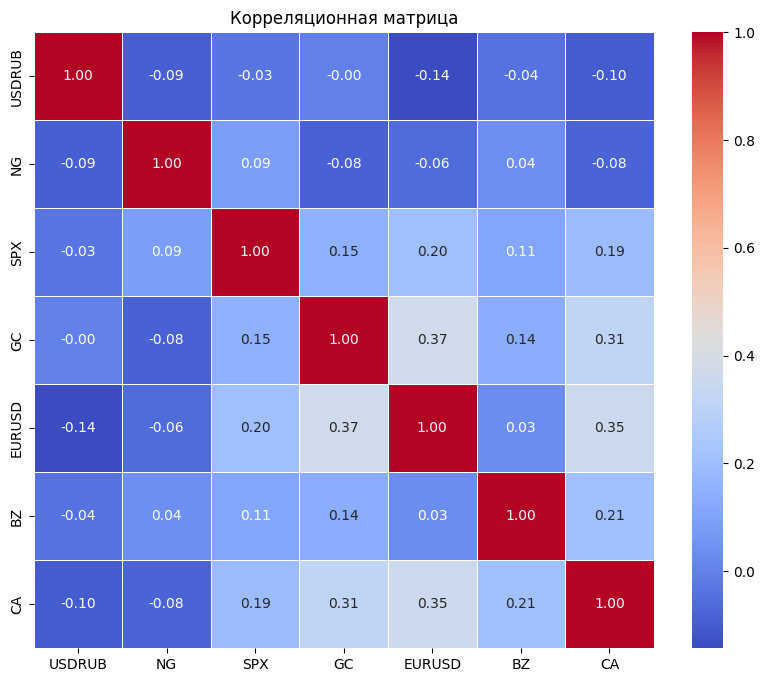

In [11]:
import seaborn as sns
corr_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Корреляционная матрица")
plt.show()

Применим регуляризацию. Параметры подберем с помощью перебора GridSearch, затем посмотрим на результаты лучших моделей.

In [12]:
lasso = Lasso()
ridge = Ridge()
elastic = ElasticNet()

# Перебор параметров регуляризации
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
param_grid_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
param_grid_elastic = {'alpha': [0.001, 0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}

grid_lasso = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_absolute_error', cv=5)
grid_lasso.fit(X_train, y_train)

grid_ridge = GridSearchCV(ridge, param_grid_ridge, scoring='neg_mean_absolute_error', cv=5)
grid_ridge.fit(X_train, y_train)

grid_elastic = GridSearchCV(elastic, param_grid_elastic, scoring='neg_mean_absolute_error', cv=5)
grid_elastic.fit(X_train, y_train)

# Вывод лучших параметров и результатов
print("Лучшие параметры для Lasso:", grid_lasso.best_params_)
print("Лучший MSE для Lasso:", -grid_lasso.best_score_)

print("Лучшие параметры для Ridge:", grid_ridge.best_params_)
print("Лучший MSE для Ridge:", -grid_ridge.best_score_)

print("Лучшие параметры для ElasticNet:", grid_elastic.best_params_)
print("Лучший MSE для ElasticNet:", -grid_elastic.best_score_)

print("\n")

best_lasso = grid_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f"MSE Lasso на тестовых данных: {mse_lasso}")
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
print(f"MAE Lasso на тестовых данных: {mae_lasso}")
print("Коэффиценты регуляризации:", best_lasso.coef_, "\n")

best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f"MSE Ridge на тестовых данных: {mse_ridge}")
mae_ridge = mean_absolute_error(y_test, y_pred_lasso)
print(f"MAE Ridge на тестовых данных: {mae_ridge}")
print("Коэффиценты регуляризации:", best_ridge.coef_, "\n")

best_elastic = grid_elastic.best_estimator_
y_pred_elastic = best_elastic.predict(X_test)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
print(f"MSE ElasticNet на тестовых данных: {mse_elastic}")
mae_elastic = mean_absolute_error(y_test, y_pred_lasso)
print(f"MAE ElasticNet на тестовых данных: {mae_elastic}")
print("Коэффиценты регуляризации:", best_elastic.coef_, "\n")

Лучшие параметры для Lasso: {'alpha': 0.01}
Лучший MSE для Lasso: 0.009375493581910522
Лучшие параметры для Ridge: {'alpha': 10}
Лучший MSE для Ridge: 0.009698128057957703
Лучшие параметры для ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.2}
Лучший MSE для ElasticNet: 0.009375493581910522


MSE Lasso на тестовых данных: 0.0002768401036866669
MAE Lasso на тестовых данных: 0.011758796379995112
Коэффиценты регуляризации: [-0. -0. -0.  0.  0.  0. -0.] 

MSE Ridge на тестовых данных: 0.0002846202654086984
MAE Ridge на тестовых данных: 0.011758796379995112
Коэффиценты регуляризации: [-8.81250933e-04 -1.01634714e-03 -3.59740160e-04  6.10092920e-04
  9.58534209e-05  7.20529768e-04 -6.58775257e-04] 

MSE ElasticNet на тестовых данных: 0.0002768401036866669
MAE ElasticNet на тестовых данных: 0.011758796379995112
Коэффиценты регуляризации: [-0. -0. -0.  0.  0.  0. -0.] 



MAE моделей с регуляризацией не отличается от MAE бащовой модели.
Также можно заметить, что "негладкие" регуляризаторы ElasticNet и  Lasso зануляют все коэффиценты у признаков, что логично, потому что мы знаем, что они незначимые.

Регуляризация не очень помогает, так как сами признаки не объясняют целевую переменную.

Обучение модели только со значимыми предикторами отсутсвует, так как среди наших признаков таких нет.